In [35]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.9.0', '0.10.0a0')

In [36]:
import os
os.environ["TORCH_HOME"] = "/raid/cs152/pytorch"

In [37]:
alexnet = torchvision.models.alexnet(pretrained=True, progress=True)

/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/torch/hub.py:526: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [38]:
fake_image = torch.randn(1, 3, 244, 244)

alexnet.eval() = alexnet.eval()
with torch.inference_mode():
    yhat = alexnet(fake_image)

In [39]:
yhat.shape

torch.Size([1, 1000])

In [40]:
import json
with open("/raid/cs152/pytorch/imagenet_class_index.json") as json_file:
    labels = json.load(json_file)

In [41]:
class_index = yhat.argmax().item()
labels[str(class_index)]

['n03980874', 'poncho']

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [73]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

resize_and_crop = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

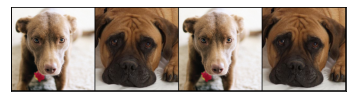

In [78]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from PIL import Image

# dog1_int = preprocess(Image.open("../data/dog1.jpg"))#preprocess(read_image(str(Path('../data') / 'dog1.jpg')))
# dog2_int = preprocess(Image.open("../data/dog2.jpg"))#preprocess(read_image(str(Path('../data') / 'dog2.jpg')))
dog1_int = resize_and_crop(read_image(str(Path('../data') / 'dog1.jpg')))
dog2_int = resize_and_crop(read_image(str(Path('../data') / 'dog2.jpg')))

grid = make_grid([dog1_int, dog2_int, dog1_int, dog2_int])
show(grid)

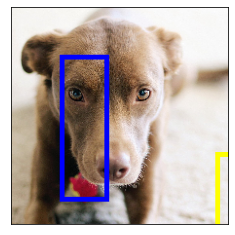

In [79]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

In [81]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype


batch_int = torch.stack([dog1_int, dog2_int])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
model = model.eval()

outputs = model(batch)
print(outputs)

[{'boxes': tensor([[  9.1012,   8.8089, 194.8979, 220.3526]], grad_fn=<StackBackward>), 'labels': tensor([18]), 'scores': tensor([0.9720], grad_fn=<IndexBackward>)}, {'boxes': tensor([[  3.1576,   6.3268, 219.1398, 211.5349],
        [180.8235,  69.8199, 223.7334, 203.9348]], grad_fn=<StackBackward>), 'labels': tensor([18, 18]), 'scores': tensor([0.9890, 0.2890], grad_fn=<IndexBackward>)}]


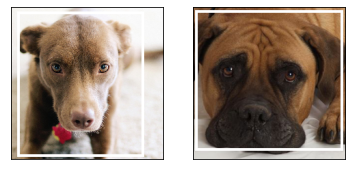

In [82]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

In [83]:
from torchvision.models.segmentation import fcn_resnet50


model = fcn_resnet50(pretrained=True, progress=True)
model = model.eval()

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([2, 21, 224, 224]) -6.766611576080322 14.150158882141113


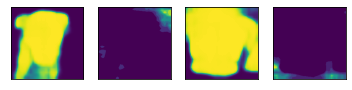

In [84]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

shape = torch.Size([2, 224, 224]), dtype = torch.bool


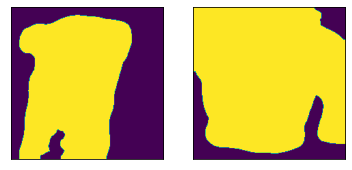

In [86]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

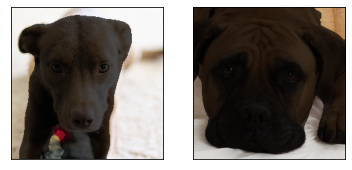

In [87]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(batch_int, boolean_dog_masks)
]
show(dogs_with_masks)

dog1_masks shape = torch.Size([21, 224, 224]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 224, 224]), dtype = torch.bool


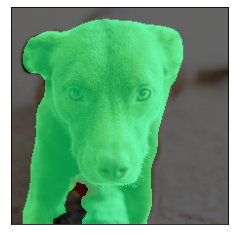

In [88]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)